# Реализация модели линейной регрессии

In [ ]:
import numpy as np


class LinearRegressorGD:

    def __init__(self, learning_rate=0.1, n_iter=4000):
        self._learning_rate = learning_rate
        self._n_iter = n_iter
        self._weights = None
        self._bias = None

    def fit(self, X, y_true):
        y_true = y_true.ravel()
        # Запоминаем размерность матрицы
        n_samples= X.shape[0]
        n_features = X.shape[1]
        # Инициализируем начальные веса нормальным распрделением
        self._weights = np.random.randn(n_features)
        self._bias = np.random.randn()

        # В данной реализации, критерий остановки - количество итераций
        for i in range(self._n_iter):
            # Предсказание, считаем как скалярное перемножение объекта на веса
            y_pred = np.dot(X, self._weights) + self._bias
            # Считаем градиенты
            grad_w = (1 / n_samples) * np.dot(X.T, (y_pred - y_true))
            grad_bias = (1 / n_samples) * np.sum(y_pred - y_true)
            #Пользуемся градиентным спуском
            self._weights = self._weights - self._learning_rate * grad_w
            self._bias = self._bias - self._learning_rate * grad_bias

    def predict(self, X):
        return np.dot(X, self._weights) + self._bias

    def get_params(self):
        d = {}
        d['x0'] = round(self._bias, 2)
        for i,j in enumerate(self._weights):
          d[f"x{i+1}"] = round(j, 2)
        return d

# Проверка модели линейной регрессии

## Подготовка датасета

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [ ]:
diamonds_df = pd.read_csv('sample_data/diamonds.csv')

In [ ]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


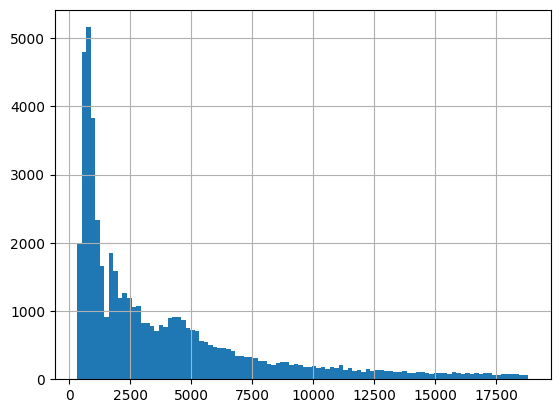

In [ ]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid();

In [ ]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [ ]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [ ]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [ ]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Тест модели

In [ ]:
reg_1 = LinearRegressorGD()
reg_2 = LinearRegression()

reg_1.fit(X_train, y_train)
reg_2.fit(X_train, y_train)


LinearRegression()

In [ ]:
y_pred_my = reg_1.predict(X_test)
y_pred_sklearn = reg_2.predict(X_test)

In [ ]:
score_my = r2_score(y_pred_my, y_test)
score_sklearn = r2_score(y_pred_sklearn, y_test)

print(f"Моя метрика R^2 {round(score_my, 3)}\nМетрика sklearn R^2 {round(score_sklearn, 3)}")

Моя метрика R^2 0.867
Метрика sklearn R^2 0.898


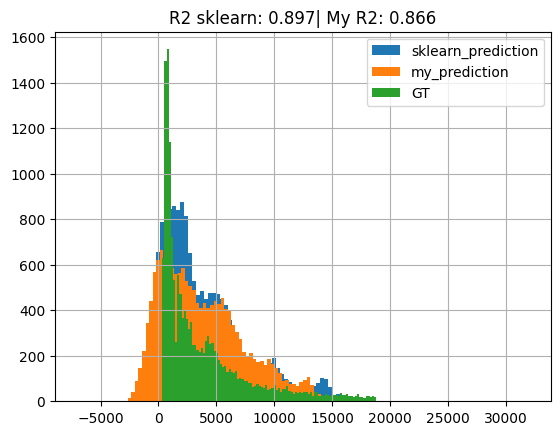

In [ ]:
plt.title(f'R2 sklearn: {str(score_sklearn)[:5]}| My R2: {str(score_my)[:5]}')
plt.hist(y_pred_sklearn.reshape(1, -1)[0], bins=100, label='sklearn_prediction')
plt.hist(y_pred_my.reshape(1, -1)[0], bins=100, label='my_prediction')

plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

# Реализация backpropagation для MLP

In [ ]:
import numpy as np

class MLPRegressor:
    def __init__(self, hidden_layer_sizes=(100,), learning_rate=0.01, n_iter=100):
        self._hidden_layer_sizes = hidden_layer_sizes
        self._learning_rate = learning_rate
        self._n_iter = n_iter
        self._weights = []
        self._biases = []

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def sigmoid_grad(x):
        sigm = 1 / (1 + np.exp(-x))
        return sigm * (1 - sigm)

    def _initialize_params(self, m, n):
        layer_sizes = [m] + list(self._hidden_layer_sizes) + [n]

        self._weights = []
        self._biases = []

        for i in range(len(layer_sizes) - 1):
            W = np.random.randn(layer_sizes[i], layer_sizes[i + 1])
            b = np.zeros((1, layer_sizes[i + 1]))
            self._weights.append(W)
            self._biases.append(b)

    def forward(self, X):
        activated = [X]
        pre_activations = []

        for i in range(len(self._weights) - 1):
            z = activated[-1] @ self._weights[i] + self._biases[i]
            pre_activations.append(z)
            a = self.sigmoid(z)
            activated.append(a)

        z = activated[-1] @ self._weights[-1] + self._biases[-1]
        pre_activations.append(z)
        activated.append(z)

        return activated, pre_activations

    def backward(self, X, y, activated, pre_activations):
        m = X.shape[0]
        y = y.reshape(-1, 1) if y.ndim == 1 else y

        delta = (activated[-1] - y) / m

        W_grads = []
        b_grads = []

        for i in reversed(range(len(self._weights))):
            w_grad = activated[i].T @ delta
            b_grad = np.sum(delta, axis=0, keepdims=True)

            W_grads.insert(0, w_grad)
            b_grads.insert(0, b_grad)

            if i > 0:
                delta = (delta @ self._weights[i].T) * self.sigmoid_grad(pre_activations[i - 1])

        for i in range(len(self._weights)):
            self._weights[i] -= self._learning_rate * W_grads[i]
            self._biases[i] -= self._learning_rate * b_grads[i]

    def fit(self, X, y):
        m = X.shape[1]
        n = 1
        self._initialize_params(m, n)
        for _ in range(self._n_iter):
            activated, pre_activations = self.forward(X)
            self.backward(X, y, activated, pre_activations)

    def predict(self, X):
        activated, _ = self.forward(X)
        return activated[-1]


# Оценка качества модели

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Сгенерируем даннные
# Будем учиться предсказывать линейнную комбинацию четырех случайных чисел
X = np.random.rand(400, 4)
y = 10 * X[:, 0] + 6 * X[:, 1] + 7 * X[:, 2] - 3 * X[:, 3]


# Разделим выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=47
)

# Создадим и обучим модель с двумя слоями
mlp = MLPRegressor(hidden_layer_sizes=(5, 5),
                   learning_rate=0.1, n_iter=2000)
mlp.fit(X_train, y_train)

# Сделаем предсказание
y_train_pred = mlp.predict(X_train).flatten()
y_test_pred = mlp.predict(X_test).flatten()

# Оценим с помощью метрик
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {round(train_mse, 3)}, R²: {round(train_r2 ,3)}")
print(f"Test  MSE: {round(test_mse, 3)}, R²: {round(test_r2, 3)}")

# --- Примеры предсказаний ---
for i in range(5):
    print(f"X={X_test[i]}, y_test={round(y_test[i], 3)}, y_pred={round(y_test_pred[i], 3)}")


Train MSE: 0.043, R²: 0.997
Test  MSE: 0.052, R²: 0.997
X=[0.59803565 0.92466102 0.03032515 0.37997294], y_test=10.601, y_pred=10.613
X=[0.38213838 0.26879134 0.18061455 0.1101478 ], y_test=6.368, y_pred=6.241
X=[0.92958193 0.99288406 0.08188126 0.81119496], y_test=13.393, y_pred=13.329
X=[0.51986303 0.0526802  0.61952535 0.94100211], y_test=7.028, y_pred=6.849
X=[0.2729829  0.47951608 0.0151622  0.67045771], y_test=3.702, y_pred=3.428
